# Computational Graphs &mdash; A Demo Application

In [130]:
import torch
import math

In [131]:
dtype = torch.float

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)
if device.type == 'cuda':
    print('Current device name:', torch.cuda.get_device_name())
    print('CUDA device count:', torch.cuda.device_count())

Current device: cpu


In [132]:
# Some parts are based on 
# https://stackoverflow.com/questions/75610911/how-to-use-mermaid-diagram-in-jupyter-notebook-with-mermaid-ink-through-proxy

import base64
from IPython.display import Image, display

def mermaid(graph: str):
    graph_bytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graph_bytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

## $\sin x$

In [133]:
# Create input and output data
x = torch.linspace(0, math.pi / 2, 2000, \
                   dtype=dtype, device=device)
x_indices = torch.randperm(2000, device=device)
x = x[x_indices]

### Computational Graph

We will fit $y = \sin x$, where $x \in [0, \pi / 2]$, with the quadratic polynomial $y = a + bx + cx^2$. There will be three parameters $a$, $b$, $c$ trained with gradient descent.

Let $a$, $b$, $c$ are weights as scalars; <br/>
$\textrm{x}$ is a vector of a finite number of values of $x \in [0, \pi / 2]$; <br/>
$\textrm{y}$ is a vector that has the same size as $\textrm{x}$, and $y_i = \sin x_i$ ($y_i$ is the $i$-th element of $\textrm{y}$); <br/>
$\textrm{t}$ is a vector that has the same size as $\textrm{x}$, and $t_i = x_i^2$ ($t_i$ is the $i$-th element of $\textrm{t}$); <br/>
$\textrm{j}$ is a vector that has the same size as $\textrm{x}$, and $j_i = 1$ ($j_i$ is the $i$-th element of $\textrm{j}$); <br/>
we have

$$\textrm{y}_{pred} = a\;\textrm{j} + b\;\textrm{x} + c\;\textrm{t}\;, \quad 
J = (\textrm{y}_{pred} - \textrm{y})^\top (\textrm{y}_{pred} - \textrm{y})$$

and
$$\frac{\partial{J}}{\partial{\textrm{y}_{pred}}} = 2 (\textrm{y}_{pred} - \textrm{y})^\top\;, \quad
\frac{\partial{\textrm{y}_{pred}}}{\partial{a}} = \textrm{j}\;, \quad 
\frac{\partial{\textrm{y}_{pred}}}{\partial{b}} = \textrm{x}\;, \quad 
\frac{\partial{\textrm{y}_{pred}}}{\partial{c}} = \textrm{t}\;.$$

In [134]:
mermaid("""graph TD;
    x --> t;
    x --> y_pred;
    t --> y_pred;
    a --> y_pred;
    b --> y_pred;
    c --> y_pred;
    y_pred --> J;
    y --> J;
""")

In [135]:
x = x.reshape(-1, 1)
y = torch.sin(x)
t = x * x
j = torch.ones(x.shape)

# Initialize weights
a = torch.randn((), dtype=dtype, device=device)
b = torch.randn((), dtype=dtype, device=device)
c = torch.randn((), dtype=dtype, device=device)

learning_rate = 1e-4
for iter in range(2000):
    
    # Forward pass: compute predicted y and loss J
    y_pred = a * j + b * x + c * t
    J = (y_pred - y).T.mm(y_pred - y)

    # Backprop to compute gradients of a, b, c with respect to loss J
    grad_y_pred = 2 * (y_pred - y).T
    grad_a = grad_y_pred.mm(j).item()
    grad_b = grad_y_pred.mm(x).item()
    grad_c = grad_y_pred.mm(t).item()

    # Update weights
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c

    # Print loss
    if iter % 100 == 99:
        print(f'Iter. {iter}: loss = {round(J.item(), 4)}')

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2')

Iter. 99: loss = 12.045
Iter. 199: loss = 5.9715
Iter. 299: loss = 2.9967
Iter. 399: loss = 1.5397
Iter. 499: loss = 0.826
Iter. 599: loss = 0.4765
Iter. 699: loss = 0.3053
Iter. 799: loss = 0.2214
Iter. 899: loss = 0.1804
Iter. 999: loss = 0.1602
Iter. 1099: loss = 0.1504
Iter. 1199: loss = 0.1456
Iter. 1299: loss = 0.1432
Iter. 1399: loss = 0.142
Iter. 1499: loss = 0.1415
Iter. 1599: loss = 0.1412
Iter. 1699: loss = 0.1411
Iter. 1799: loss = 0.141
Iter. 1899: loss = 0.141
Iter. 1999: loss = 0.1409
Result: y = -0.024060139432549477 + 1.1949108839035034 x + -0.33776161074638367 x^2


### Gradient Descent


This is what the math looks like if we just use gradient descent:
$$y_{pred} = a + bx + cx^2$$
$$J = \sum_{x} {(y_{pred} - y)^2}$$
$$\frac{\partial{J}}{\partial{a}} = 2 \sum_{x} (y_{pred} - y) \;\frac{\partial{}}{\partial{a}}(a + bx + cx^2 - y) = 2 \sum_{x} (y_{pred} - y)$$
$$\frac{\partial{J}}{\partial{b}} = 2 \sum_{x} (y_{pred} - y) \;\frac{\partial{}}{\partial{b}}(a + bx + cx^2 - y) = 2 \sum_{x} (y_{pred} - y)x$$
$$\frac{\partial{J}}{\partial{c}} = 2 \sum_{x} (y_{pred} - y) \;\frac{\partial{}}{\partial{c}}(a + bx + cx^2 - y) = 2 \sum_{x} (y_{pred} - y)x^2$$

In [136]:
# Some parts are based on https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

y = torch.sin(x)

# Initialize weights
a = torch.randn((), dtype=dtype, device=device)
b = torch.randn((), dtype=dtype, device=device)
c = torch.randn((), dtype=dtype, device=device)

learning_rate = 1e-4
for iter in range(2000):    
    
    # Forward pass: compute predicted y
    y_pred_2 = a + b * x + c * x ** 2

    # Compute and print loss
    loss = (y_pred_2 - y).pow(2).sum().item()
    if iter % 100 == 99:
        print(f'Iter. {iter}: loss = {round(loss, 4)}')
    
    # Backpropagation to compute gradients of a, b, c with respect to loss
    grad_loss = 2.0 * (y_pred_2 - y)
    grad_a = grad_loss.sum()
    grad_b = (grad_loss * x).sum()
    grad_c = (grad_loss * x ** 2).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2')


Iter. 99: loss = 66.4674
Iter. 199: loss = 32.6273
Iter. 299: loss = 16.0526
Iter. 399: loss = 7.9344
Iter. 499: loss = 3.9581
Iter. 599: loss = 2.0106
Iter. 699: loss = 1.0567
Iter. 799: loss = 0.5895
Iter. 899: loss = 0.3606
Iter. 999: loss = 0.2485
Iter. 1099: loss = 0.1936
Iter. 1199: loss = 0.1667
Iter. 1299: loss = 0.1536
Iter. 1399: loss = 0.1471
Iter. 1499: loss = 0.144
Iter. 1599: loss = 0.1424
Iter. 1699: loss = 0.1417
Iter. 1799: loss = 0.1413
Iter. 1899: loss = 0.1411
Iter. 1999: loss = 0.141
Result: y = -0.023754866793751717 + 1.1938657760620117 x + -0.33713164925575256 x^2


### Visualization

          x         y  y_pred (CG)  y_pred (GD)
0  0.221593  0.219784     0.224139     0.224244
1  0.320603  0.315139     0.324314     0.324350
2  0.117083  0.116816     0.111214     0.111406
3  0.984596  0.833049     0.825008     0.824895
4  1.116609  0.898618     0.889062     0.888985


C:\Users\C15TQK\AppData\Local\Temp\ipykernel_3968\1627016959.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x='x', y='y', palette='blue')
C:\Users\C15TQK\AppData\Local\Temp\ipykernel_3968\1627016959.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x='x', y='y_pred (CG)', palette='green')
C:\Users\C15TQK\AppData\Local\Temp\ipykernel_3968\1627016959.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x='x', y='y_pred (GD)', palette='red')


<Axes: xlabel='x', ylabel='y'>

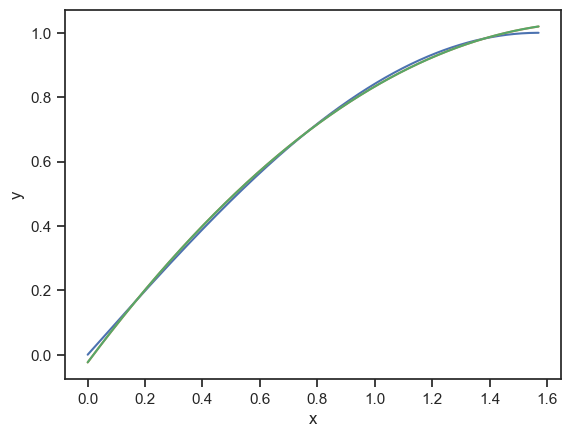

In [141]:
import pandas as pd
import seaborn as sns
sns.set_theme(style='ticks')

df = torch.stack( \
    (x.reshape(-1), y.reshape(-1), y_pred.reshape(-1), y_pred_2.reshape(-1)) \
        ).t().numpy()
df = pd.DataFrame(df, columns=['x', 'y', 'y_pred (CG)', 'y_pred (GD)'])

print(df.head())

sns.lineplot(data=df, x='x', y='y', palette='blue')
sns.lineplot(data=df, x='x', y='y_pred (CG)', palette='green')
sns.lineplot(data=df, x='x', y='y_pred (GD)', palette='red')

The blue curve and the red curve represent values of $\sin x$ and predicted values using the polynomial, respectively.